# Forecast TDS9
Testa facebook prophet forecast modell på TDS9 data

## Ladda bibliotek

In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet

## Läs in data
Tillgänglig data är från och med 2013-01-01 till och med 2020-01-31

In [468]:
df = pd.read_csv('data\TDS9-2013-01-01-2020-01-31.csv', sep=';', decimal=',', usecols= ['timestamp', 'property', 'consumption_value', 'temperature'])
df = df[df.property == 'energy']
df.head()

,timestamp,property,consumption_value,temperature
0,2013-01-02T00:00:00Z,energy,2.60,6.04042
1,2013-01-03T00:00:00Z,energy,2.75,4.33474
2,2013-01-04T00:00:00Z,energy,2.61,5.74339
3,2013-01-05T00:00:00Z,energy,2.96,2.56162
4,2013-01-06T00:00:00Z,energy,3.37,-0.28711


Ändra från timestamp sträng till datum

In [490]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

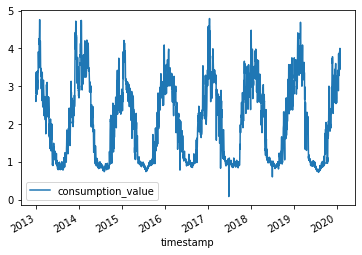

In [485]:
df.plot('timestamp', 'consumption_value')

Ta bort uppenbar outlier och interpolera värdet

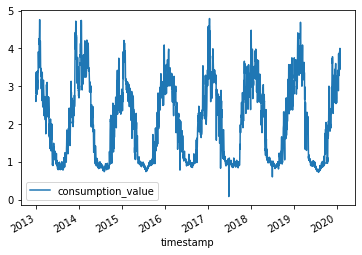

In [486]:
df.loc[df.consumption_value<-1000, 'consumption_value'] = np.nan
df.loc[:,'consumption_value'] = df.assign(consumption_value = df.consumption_value.interpolate(method='linear'))
df.plot('timestamp', 'consumption_value')

## Forecasting

Börjar med att förbereda data frame för prophet forecasting, datum kolumn måste heta ds och variabeln y.  
För prognostävlingen skall resultat utvärderas på senaste året vilket blir 2019, detta år exkluderas därför och 2018 används som testår och 2013-2017 som träningsår.  

In [488]:
df_m = df[['timestamp', 'consumption_value']]
df_m.columns = ['ds', 'y']

train = df_m[df_m['ds'] <= '2017-12-31']
test = df_m[(df_m.ds > '2017-12-31') & (df_m.ds <= '2018-12-31')]
validate = df_m[df_m.ds > '2018-12-31']

test.head()

,ds,y
1820,2018-01-01,2.38
1821,2018-01-02,2.88
1822,2018-01-03,3.52
1823,2018-01-04,3.10
1824,2018-01-05,3.63


Träna default prophet modell

In [491]:
m = Prophet()
m.fit(train)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Visualisera resultat

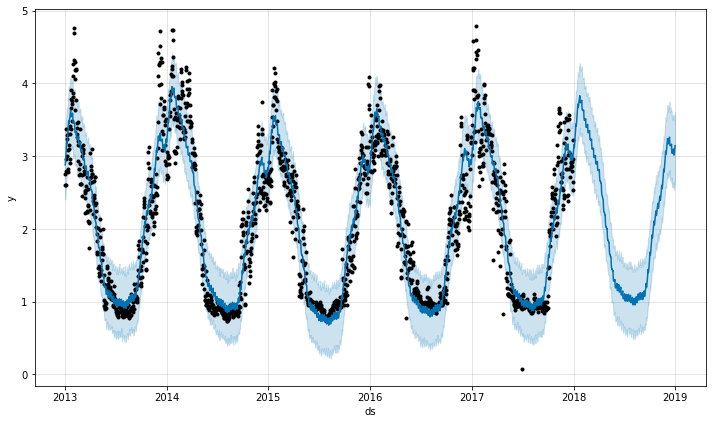

In [495]:
fig = m.plot(forecast)

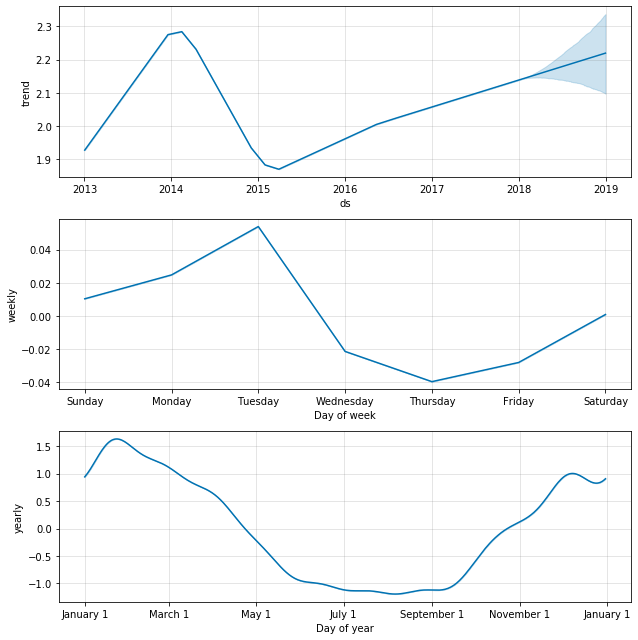

In [496]:
fig = m.plot_components(forecast)

### Beräkna fel  
RMSE och MAPE

In [497]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test.y, forecast.yhat[-365:], squared=False)

0.35337958669756436

In [498]:
import numpy as np

def mean_absolute_percentage_error(y_pred, y_true):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [499]:
mean_absolute_percentage_error(forecast.yhat[-365:], test.y)

15.336418467177678

### Plotta endast test period

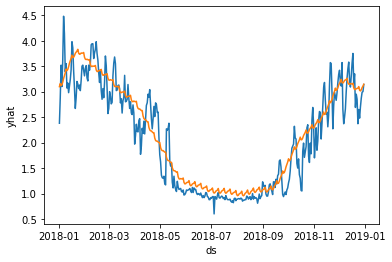

In [505]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2018-01-01'])

Weekly seasonality verkar lägga till onödig variation, testar att ta bort

In [506]:
m2 = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True)
m2.fit(train)

future2 = m2.make_future_dataframe(periods=365)
forecast2 = m2.predict(future2)

mean_absolute_percentage_error(forecast2.yhat[-365:], test.y)


15.406423657122852

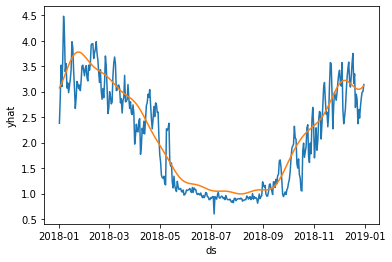

In [507]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast2[forecast2.ds>='2018-01-01'])

Ej lägre MAPE men ser rimligare ut

Titta på residualer

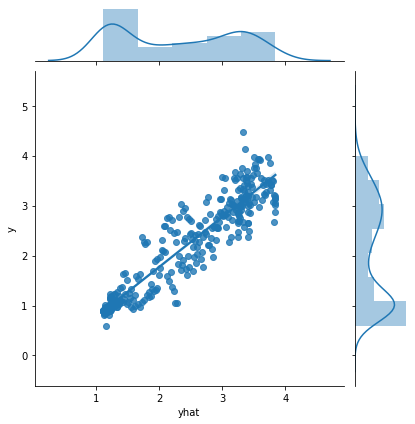

In [510]:
import seaborn as sns

df_merged = df_m.merge(forecast2[['ds', 'yhat']], left_on='ds', right_on='ds')
sns.jointplot("yhat", "y", data=df_merged[df_merged.ds >= '2018-01-01'], kind="reg")


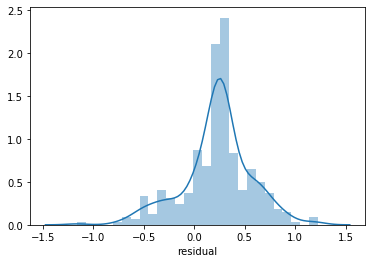

In [511]:
df_merged['residual'] = df_merged.yhat - df_merged.y

sns.distplot(df_merged[df_merged.ds >= '2018-01-01']['residual'])

## Temperatur som extra regressor

In [513]:
df_m_temp = df[['timestamp', 'consumption_value', 'temperature']]
df_m_temp.columns = ['ds', 'y', 'temp']

train = df_m_temp[df_m_temp['ds'] <= '2017-12-31']
test = df_m_temp[(df_m_temp.ds > '2017-12-31') & (df_m.ds <= '2018-12-31')]
validate = df_m_temp[df_m_temp.ds > '2018-12-31']

m_temp = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True,
            ).add_regressor('temp', prior_scale=0.5, mode = 'multiplicative')

m_temp.fit(train)

future_temp = m_temp.make_future_dataframe(periods=365)
future_temp['temp'] = df_m_temp['temp']

forecast_temp = m_temp.predict(future_temp)

mean_absolute_percentage_error(forecast_temp.yhat[-365:], test.y)


11.921043553770595

MAPE minskar från 15.4 till 11.9

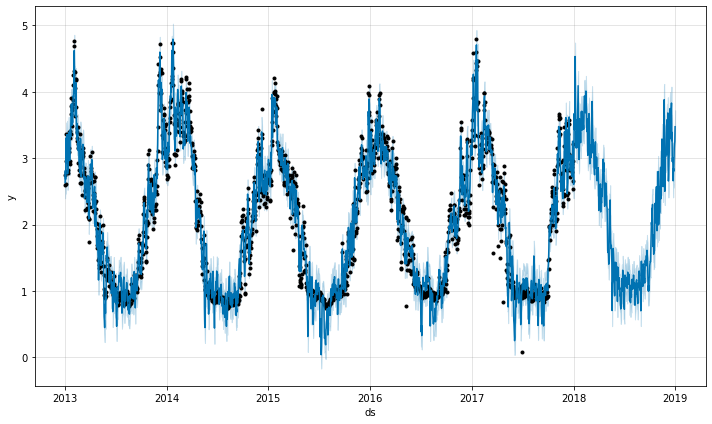

In [516]:
f = m_temp.plot(forecast_temp)

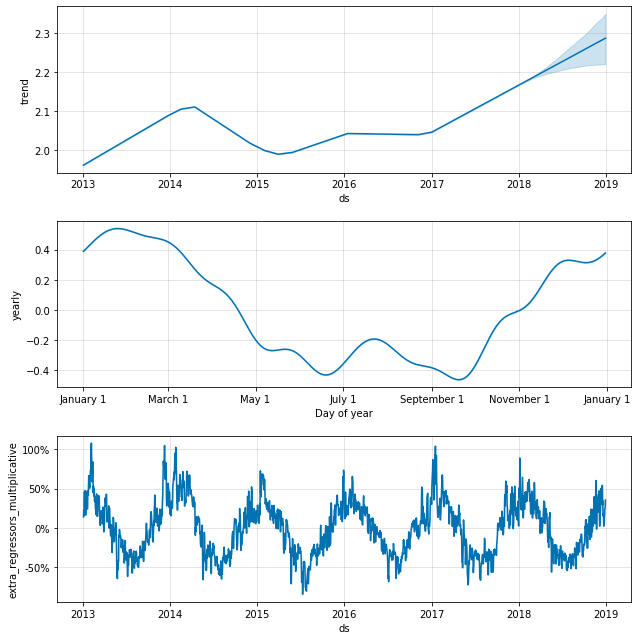

In [517]:
fig = m_temp.plot_components(forecast_temp)

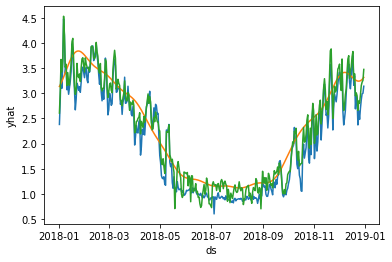

In [518]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast2[forecast2.ds>='2018-01-01'])
sns.lineplot(x = 'ds', y = 'yhat', data=forecast_temp[forecast_temp.ds>='2018-01-01'])


Kan modellen förbätras med en extra regressor för temperaturer under 15C? Detta då det ickelinjära förhållandet är som starkast kring brytpunkten vid 15C

In [519]:
df_m_temp['temp_below_15'] = (df_m_temp.temp < 15).astype('int')

train = df_m_temp[df_m_temp['ds'] <= '2017-12-31']
test = df_m_temp[(df_m_temp.ds > '2017-12-31') & (df_m.ds <= '2018-12-31')]
validate = df_m_temp[df_m_temp.ds > '2018-12-31']

m_temp2 = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True
            ).add_regressor('temp', prior_scale=0.1, mode = 'multiplicative'
            ).add_regressor('temp_below_15', prior_scale=0.9, mode = 'multiplicative')

m_temp2.fit(train)



future_temp2 = m_temp2.make_future_dataframe(periods=365)
future_temp2['temp'] = df_m_temp['temp']
future_temp2['temp_below_15'] = df_m_temp['temp_below_15']

forecast_temp2 = m_temp2.predict(future_temp2)

mean_absolute_percentage_error(forecast_temp2.yhat[-365:], test.y)


10.82912318064599

MAPE minskad med ca 1% efter tillägg av dummy regressor

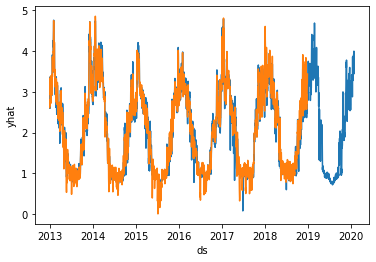

In [521]:
sns.lineplot(x = 'ds', y = 'y', data=df_m_temp)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast_temp2)

Trots minskat fel ser inte dummy regressorn ut att ha löst problemet med den för stora variationen för sommarmånaderna

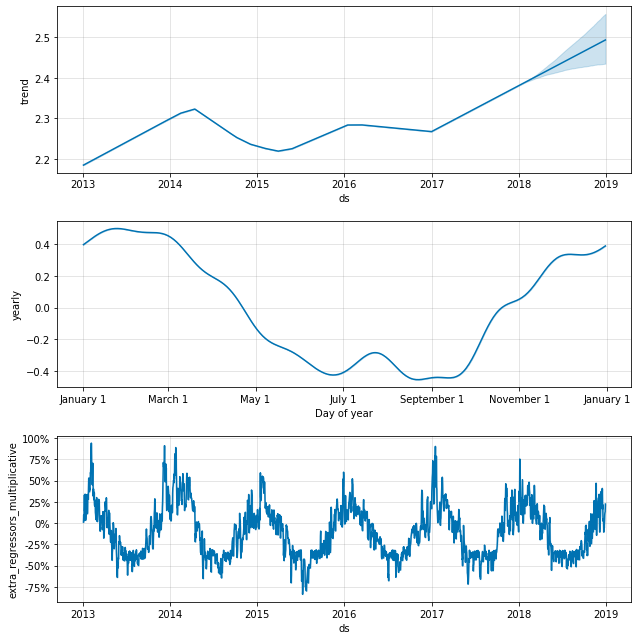

In [522]:
fig = m_temp2.plot_components(forecast_temp2)

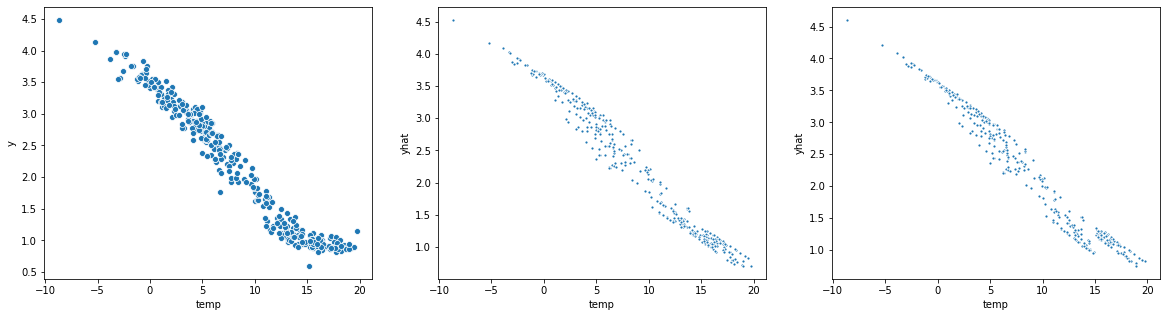

In [539]:
axes = plt.subplots(1,3, figsize=(20,5))
sns.scatterplot(x = 'temp', y = 'y', data=test, ax = axes[1][0])
sns.scatterplot(test.temp, y = forecast_temp[forecast_temp.ds>='2018-01-01'].yhat, marker='.', ax = axes[1][1])
sns.scatterplot(test.temp, y = forecast_temp2[forecast_temp2.ds>='2018-01-01'].yhat, marker='.', ax = axes[1][2])

Liten skillnad mellan modellerna med och utan dummy variabel, ser dock fortsatt linjärt ut

## Transformera temperatur regressor
Då förhållandet temperatur-energi är icke linjärt vill jag testa om det går att transformera temperatur till ett mer linjärt förhållande.

Det största problemet ligger som sagt vid 15C, om detta kan korrigeras till mer linjärt förhållande kanske forecast kan förbättras för sommarmånaderna. Det icke linjära förhållandet verkar inte påverka prognosen lika mycket då energiförbrukningen är högre.

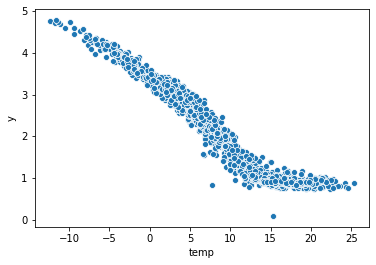

In [540]:
sns.scatterplot(x = 'temp', y = 'y', data=train)

Som första test konverterar jag till Kelvin för att kringå problemet med negativa och positiva värden samt normaliserar på min och 15 grader varefter jag sätter alla normaliserade värden över 1 till 1 (motsvarande alla temperaturer över 15C sätts till 15C)

In [600]:
df_m_temp['temp_K'] = df_m_temp.temp+273.15
df_m_temp['temp_K_norm'] = ((df_m_temp.temp_K-df_m_temp.temp_K.min())/((15+273.15)-df_m_temp.temp_K.min())).clip(upper=1)

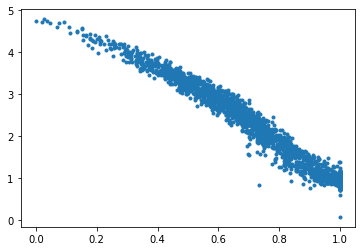

In [603]:
plt.plot(df_m_temp.temp_K_norm, df_m_temp.y, '.')

In [617]:
train = df_m_temp[df_m_temp['ds'] <= '2017-12-31']
test = df_m_temp[(df_m_temp.ds > '2017-12-31') & (df_m.ds <= '2018-12-31')]
validate = df_m_temp[df_m_temp.ds > '2018-12-31']

m_temp_trans = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True
            ).add_regressor('temp_K_norm', prior_scale=0.5, mode = 'multiplicative')

m_temp_trans.fit(train)

future_temp_trans = m_temp_trans.make_future_dataframe(periods=365)
future_temp_trans['temp_K_norm'] = df_m_temp['temp_K_norm']

forecast_temp_trans = m_temp_trans.predict(future_temp_trans)

mean_absolute_percentage_error(forecast_temp_trans.yhat[-365:], test.y)

7.855502482414982

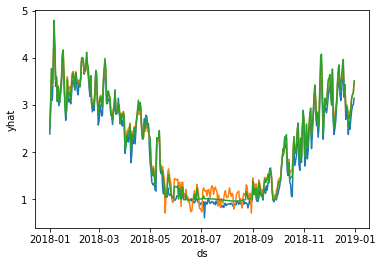

In [607]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast_temp[forecast_temp.ds>='2018-01-01'])
sns.lineplot(x = 'ds', y = 'yhat', data=forecast_temp_trans[forecast_temp_trans.ds>='2018-01-01'])

Felet minskar med 3% och modellen är dominerad av tidsserie komponent för sommarmånaderna.  
Tittar man på komponenterna för modellen kan vi se att för extra regressor är de som avklippta för höga temperaturer. Kanske blir resultatet rimligare om man istället för att abrupt klippa temperaturer vid 15C att istället gör ett mjukare avslut.

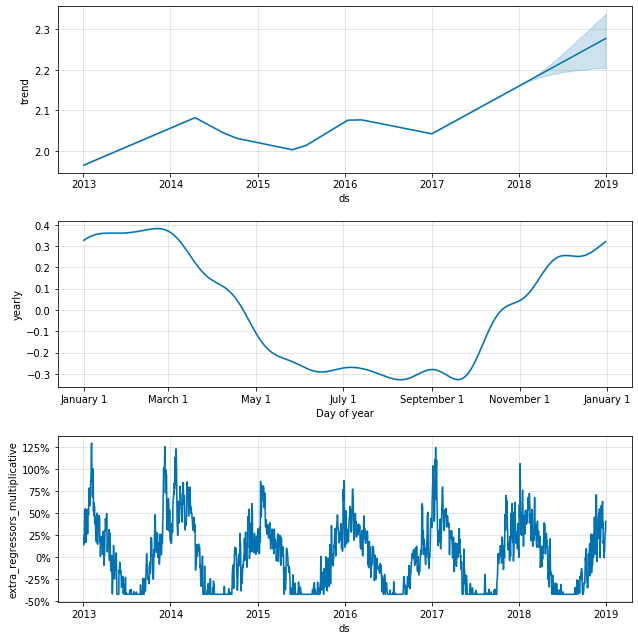

In [608]:
fig = m_temp_trans.plot_components(forecast_temp_trans)

Istället för att sätta alla normaliserade värden över 1 till 1 så minskar jag normaliserade värden över 1 med 20% (godtyckligt) för att behålla en del av temperaturberoendet men ändå minska det för varmare temperaturer.

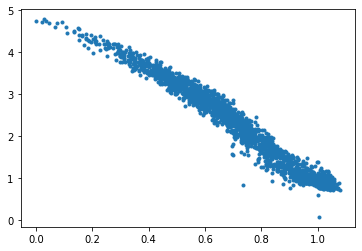

In [609]:
def transform_temperature(t):
    temp_K = t + 273.15
    temp_K_norm = ((temp_K-temp_K.min())/((15+273.15)-temp_K.min()))#.clip(upper=1)
    temp_K_norm[temp_K_norm>1] = 1 + (temp_K_norm[temp_K_norm>1]-1)*0.2
    return temp_K_norm

df_m_temp['temp_trans'] = transform_temperature(df_m_temp.temp)

plt.plot(df_m_temp.temp_trans, df.consumption_value, '.')

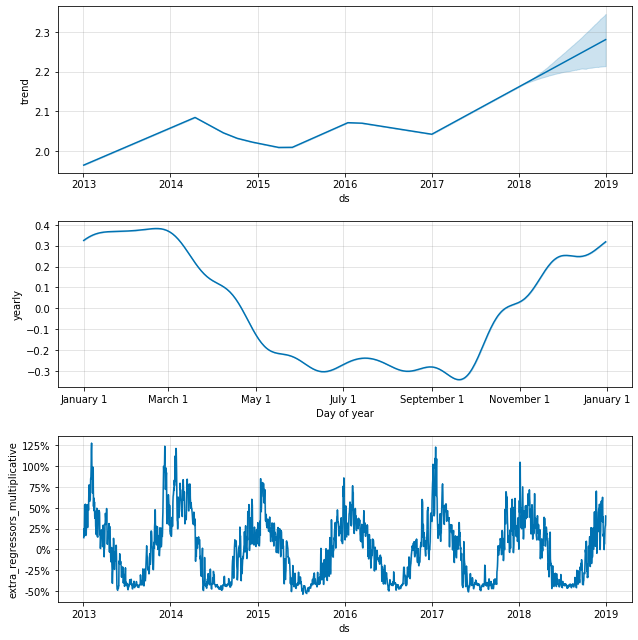

In [646]:
train = df_m_temp[df_m_temp['ds'] <= '2017-12-31']
test = df_m_temp[(df_m_temp.ds > '2017-12-31') & (df_m_temp.ds <= '2018-12-31')]
validate = df_m_temp[df_m_temp.ds > '2018-12-31']

m_temp_trans2 = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True
             ).add_regressor('temp_trans', prior_scale=0.5, mode = 'multiplicative')
m_temp_trans2.fit(train)

future_tt = m_temp_trans2.make_future_dataframe(periods=365)
future_tt['temp_trans'] = df_m_temp['temp_trans']

forecast_tt = m_temp_trans2.predict(future_tt)

fig = m_temp_trans2.plot_components(forecast_tt)

In [647]:
mean_absolute_percentage_error(forecast_tt.yhat[-365:], test.y)

8.520400128396954

Något högre fel än men resultatet ser rimligare ut

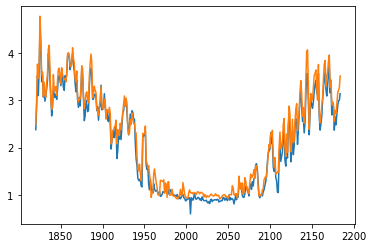

In [648]:
plt.plot(test.y)
plt.plot(forecast_tt.yhat[-365:])
#plt.plot(forecast_temp_trans.yhat[-365:])

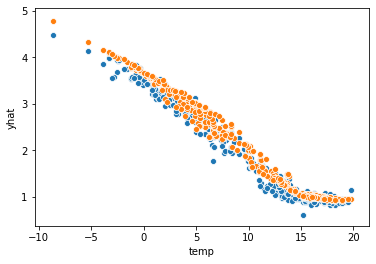

In [649]:
#sns.scatterplot(x='temp', y='y', data=train)
sns.scatterplot(x='temp', y='y', data=test)

sns.scatterplot(x=test.temp, y=forecast_tt.yhat[-365:])

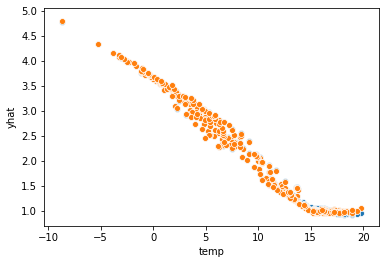

In [650]:
sns.scatterplot(x=test.temp, y=forecast_tt.yhat[-365:])
sns.scatterplot(x=test.temp, y=forecast_temp_trans.yhat[-365:])

(0.8, 1.2)

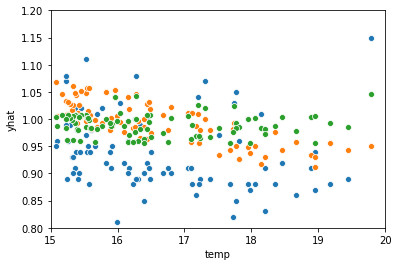

In [651]:
sns.scatterplot(x='temp', y='y', data=test)
sns.scatterplot(x=test.temp, y=forecast_tt.yhat[-365:])
ax =sns.scatterplot(x=test.temp, y=forecast_temp_trans.yhat[-365:])
ax.set_xlim(15,20)
ax.set_ylim(0.8,1.2)


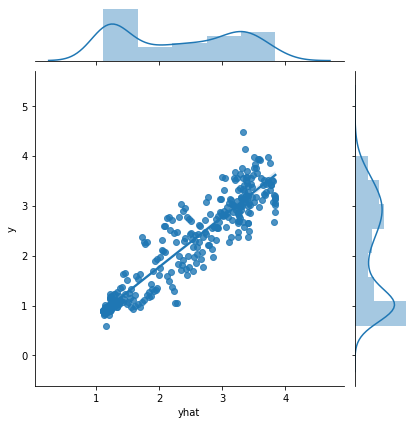

In [652]:
df_merged_temp = df_m_temp.merge(forecast_tt[['ds', 'yhat']], left_on='ds', right_on='ds')
df_merged_temp = df_merged_temp.merge(forecast_temp_trans[['ds', 'yhat']], left_on='ds', right_on='ds', suffixes=['', '_clip'])
df_merged_temp['residual'] = df_merged_temp.y-df_merged_temp.yhat
df_merged_temp['residual_clip'] = df_merged_temp.y-df_merged_temp.yhat_clip

sns.jointplot("yhat", "y", data=df_merged[df_merged.ds >= '2018-01-01'], kind="reg")

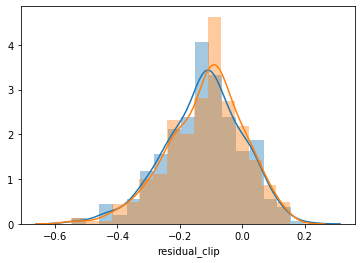

In [653]:
sns.distplot(df_merged_temp[(df_merged_temp.ds<='2018-12-31') & (df_merged_temp.ds > '2017-12-31')]['residual'])
sns.distplot(df_merged_temp[(df_merged_temp.ds<='2018-12-31') & (df_merged_temp.ds > '2017-12-31')]['residual_clip'])

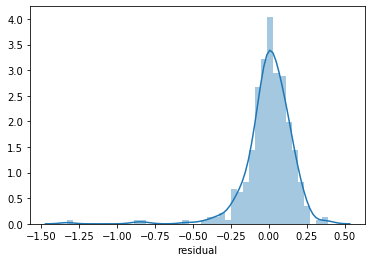

In [654]:
sns.distplot(df_merged_temp[(df_merged_temp.ds<='2017-12-31') & (df_merged_temp.ds > '2016-12-31')]['residual'])

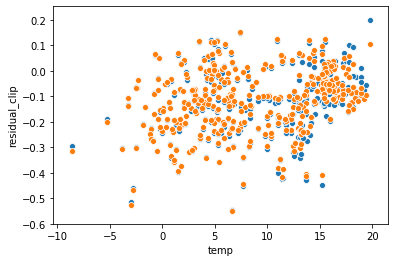

In [655]:
sns.scatterplot(x='temp', y='residual', data=df_merged_temp[df_merged_temp.ds > '2017-12-31'])
sns.scatterplot(x='temp', y='residual_clip', data=df_merged_temp[df_merged_temp.ds > '2017-12-31'])

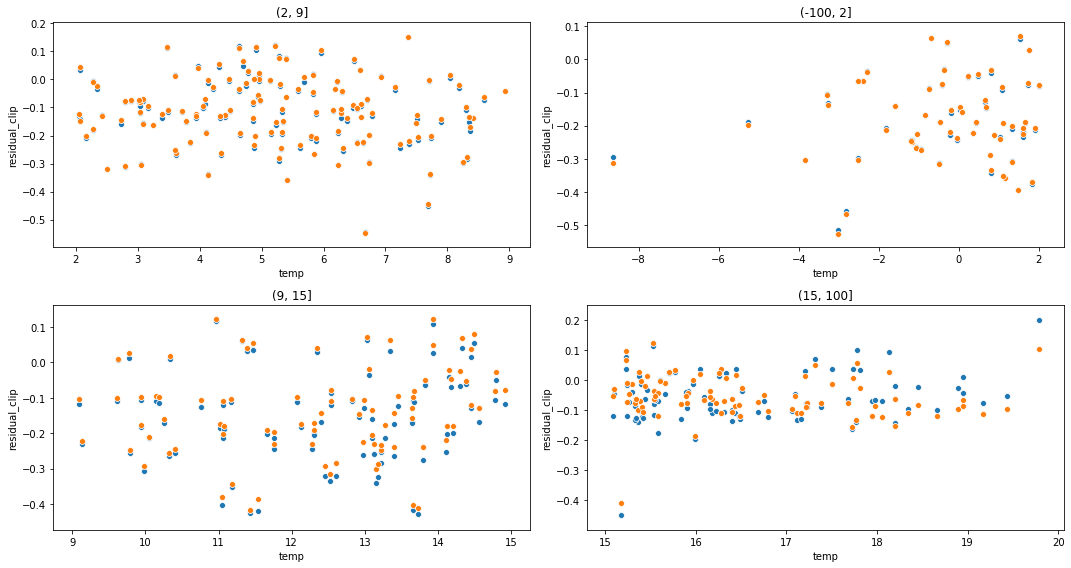

In [656]:
df_merged_temp['Interval'] = pd.cut(df_merged_temp['temp'], [-100, 2, 9, 15, 100])

intervals = df_merged_temp.Interval.unique()
fig, axes = plt.subplots(2,2, figsize=(15,8))
for i, ax in enumerate(axes.flat):
    d = df_merged_temp[(df_merged_temp.ds > '2017-12-31') & (df_merged_temp.Interval == intervals[i])]
    sns.scatterplot(x='temp', y='residual', data=d, ax = ax)
    sns.scatterplot(x='temp', y='residual_clip', data=d, ax = ax)
    ax.set(title = intervals[i])
    
plt.tight_layout()

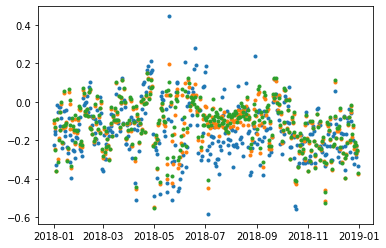

In [665]:
df_merged_temp = df_merged_temp.merge(forecast_temp[['ds', 'yhat']], left_on='ds', right_on='ds', suffixes=['', '_orig'])
df_merged_temp['residual_orig'] = df_merged_temp.y-df_merged_temp.yhat_orig

ev_df = df_merged_temp[(df_merged_temp.ds<='2018-12-31') & (df_merged_temp.ds > '2017-12-31')]
plt.plot(ev_df.ds, ev_df.residual_orig, '.')
plt.plot(ev_df.ds, ev_df.residual, '.')
plt.plot(ev_df.ds, ev_df.residual_clip, '.')

#ax = sns.scatterplot(x='ds', y='residual_clip', data=ev_df)
#ax.set_xlim(ev_df.ds.min(), ev_df.ds.max())

## Mer väderdata

In [714]:
weather = pd.read_csv('data/ESGG.txt')
weather.head()

C:\Users\idalu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,...,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar
0,ESGG,2013-01-01 06:20,37.4,37.4,100.0,220.0,11.0,0.0,29.26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.29,ESGG 010620Z 22011KT 9999 SCT005 BKN016 03/03 ...
1,ESGG,2013-01-01 06:50,37.4,37.4,100.0,220.0,11.0,0.0,29.26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.29,ESGG 010650Z 22011KT 9999 BKN003 03/03 Q0991 R...
2,ESGG,2013-01-01 07:20,37.4,37.4,100.0,230.0,10.0,0.0,29.29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.74,ESGG 010720Z 23010KT 9999 OVC004 03/03 Q0992 R...
3,ESGG,2013-01-01 07:50,37.4,37.4,100.0,220.0,10.0,0.0,29.29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.74,ESGG 010750Z 22010KT 9999 BKN005 03/03 Q0992 R...
4,ESGG,2013-01-01 08:20,37.4,37.4,100.0,220.0,11.0,0.0,29.29,NaN,...,NaN,BR,NaN,NaN,NaN,NaN,NaN,NaN,29.29,ESGG 010820Z 22011KT 9000 BR OVC003 03/03 Q099...


Kolumner med färre än 5% nans

In [715]:
completeness = round(100*weather.isna().sum()/len(weather), 0)
completeness[list(completeness[completeness < 5].index)]
#date         tmpc  dwpc  relh  drct  sknt  alti  vsby


station    0.0
valid      0.0
tmpf       0.0
dwpf       0.0
relh       0.0
drct       2.0
sknt       0.0
p01i       0.0
alti       0.0
vsby       0.0
feel       3.0
metar      0.0
dtype: float64

In [716]:
weather.p01i.sum() # alla värden 0, exkludera

0.0

Variabel förklaring

* station: three or four character site identifier
* valid: timestamp of the observation (UTC)
* tmpf: Air Temperature in Fahrenheit, typically @ 2 meters
* dwpf: Dew Point Temperature in Fahrenheit, typically @ 2 meters
* relh: Relative Humidity in %
* drct: Wind Direction in degrees from north
* sknt: Wind Speed in knots
* alti: Pressure altimeter in inches
* vsby: Visibility in miles

dew point relaterar till luftfuktigheten

Konvertera tmpf från Farenheit till Celsius

In [717]:
def F_to_C(f):
    return (f-32.)/1.8

weather['tmpc'] = weather['tmpf'].apply(F_to_C)

Vilka variabler är korrelerade?

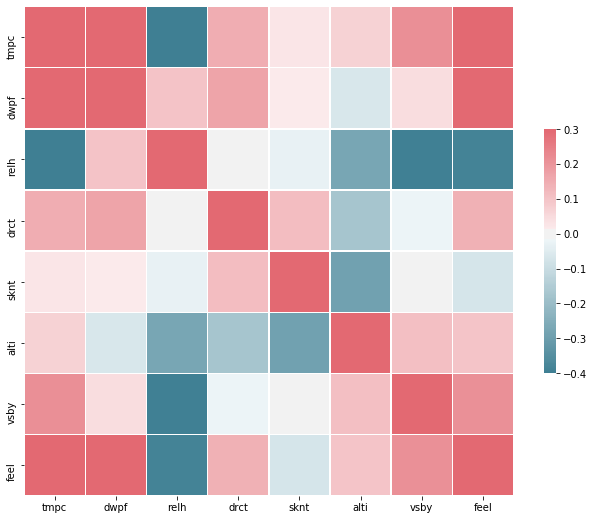

In [719]:
d = weather[['tmpc', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'feel']]
corr = d.corr()

# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=.3, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [720]:
corr

,tmpc,dwpf,relh,drct,sknt,alti,vsby,feel
tmpc,1.000000,0.866683,-0.400583,0.147811,0.026471,0.070382,0.212474,0.989507
dwpf,0.866683,1.000000,0.102089,0.170450,0.017087,-0.065846,0.045373,0.862805
relh,-0.400583,0.102089,1.000000,0.010648,-0.030816,-0.274158,-0.394169,-0.386455
drct,0.147811,0.170450,0.010648,1.000000,0.113015,-0.171679,-0.022043,0.143388
sknt,0.026471,0.017087,-0.030816,0.113015,1.000000,-0.287230,-0.013875,-0.069537
alti,0.070382,-0.065846,-0.274158,-0.171679,-0.287230,1.000000,0.109079,0.099412
vsby,0.212474,0.045373,-0.394169,-0.022043,-0.013875,0.109079,1.000000,0.212151
feel,0.989507,0.862805,-0.386455,0.143388,-0.069537,0.099412,0.212151,1.000000


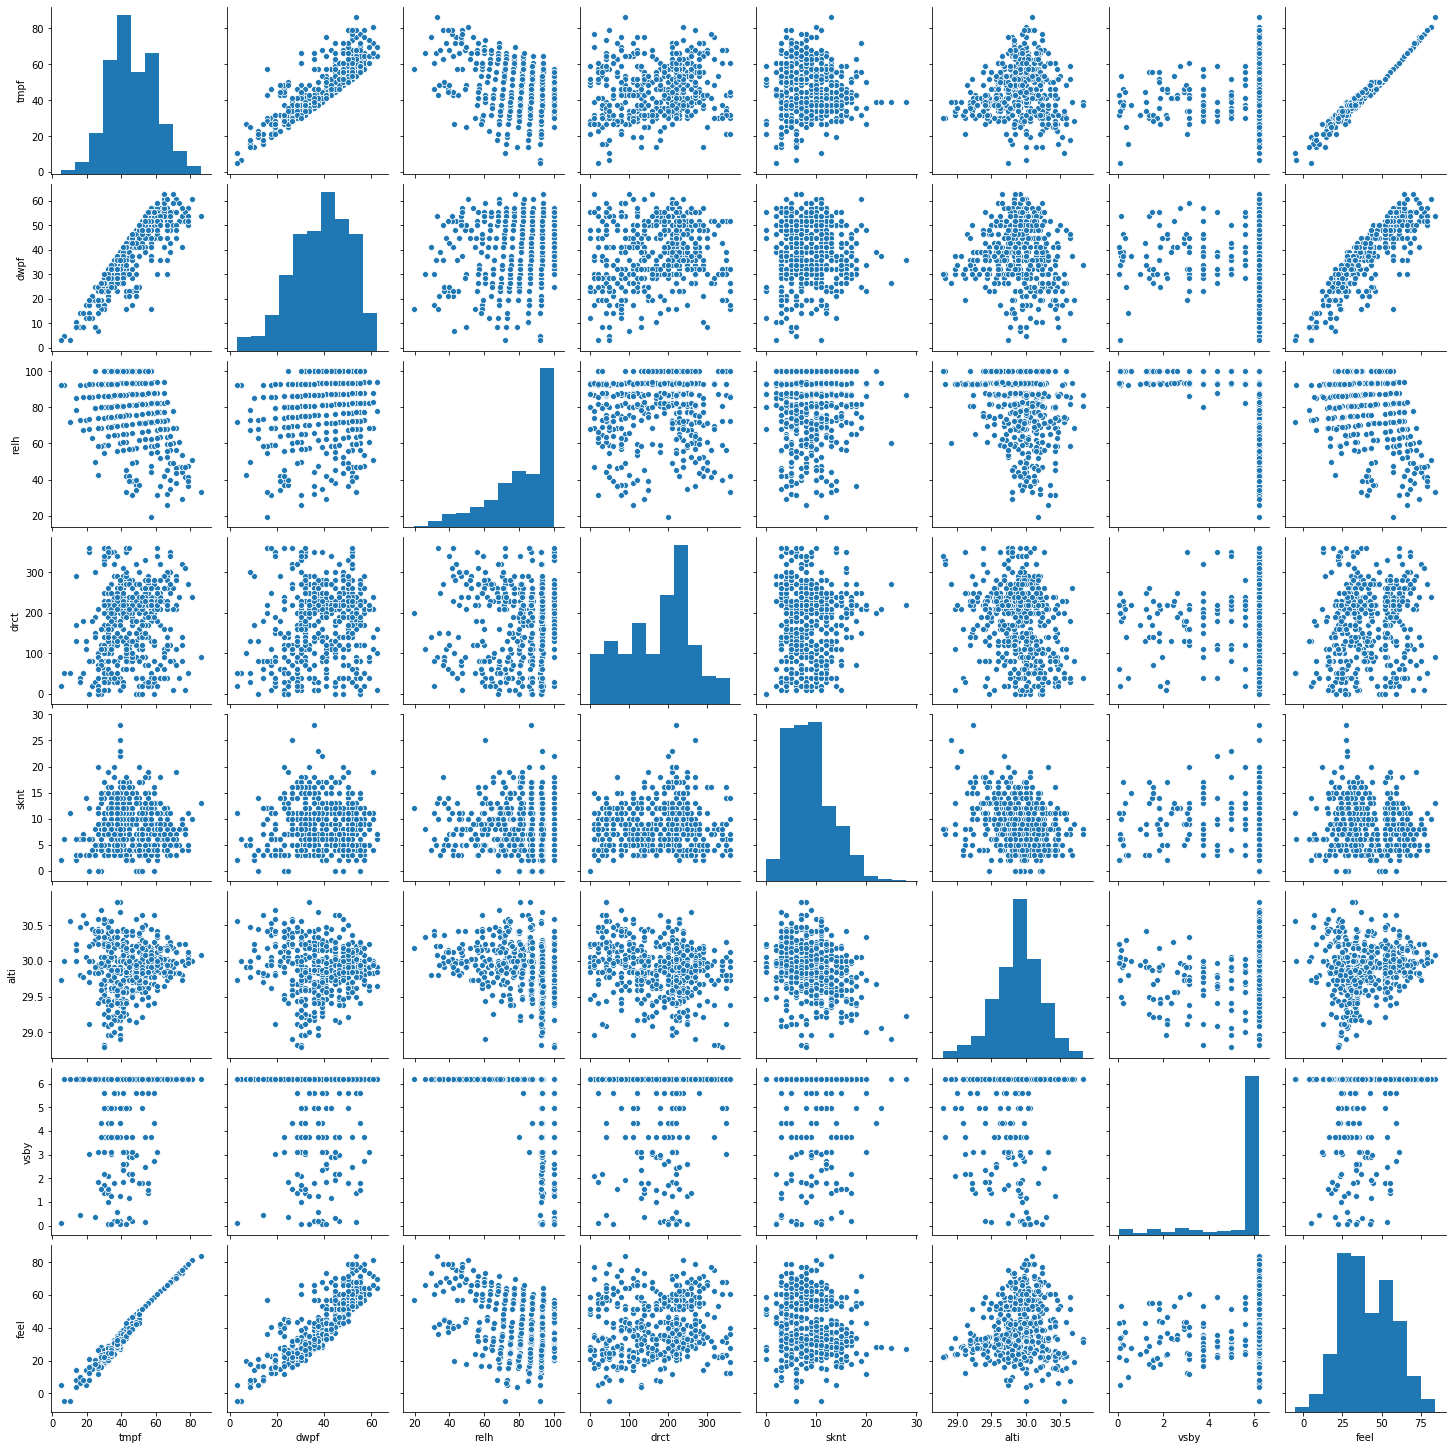

In [693]:
sns.pairplot(d.sample(500))

exkluderar feel och dwpf pga hög korrelation med temperatur, 

C:\Users\idalu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


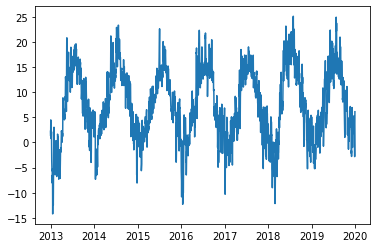

In [721]:
w = weather[['valid', 'tmpc', 'relh', 'drct', 'sknt', 'alti', 'vsby']]
w['valid'] = pd.to_datetime(w['valid']) 
w = w.resample('D', on='valid').mean()

sns.lineplot(data=w['tmpc'])

In [731]:
df_merged_weather = df_m_temp.merge(w, left_on='ds', right_on='valid', how='left')
df_merged_weather.head()

,ds,y,temp,temp_below_15,temp_K,temp_K_norm,temp_trans,tmpc,relh,drct,sknt,alti,vsby
0,2013-01-02,2.60,6.04042,1,279.19042,0.672679,0.672679,1.288889,99.387556,226.000000,7.333333,29.718222,2.483556
1,2013-01-03,2.75,4.33474,1,277.48474,0.610365,0.610365,4.479167,88.151667,257.083333,13.708333,29.768750,4.965000
2,2013-01-04,2.61,5.74339,1,278.89339,0.661827,0.661827,4.062500,92.797917,244.888889,7.854167,30.021875,4.891458
3,2013-01-05,2.96,2.56162,1,275.71162,0.545588,0.545588,1.062500,98.551042,160.227273,4.416667,30.268750,2.625000
4,2013-01-06,3.37,-0.28711,1,272.86289,0.441515,0.441515,2.108696,97.283043,122.888889,5.043478,30.154565,3.712391


Är temperatur från TDS filen liknande temperatur från Landvetter?

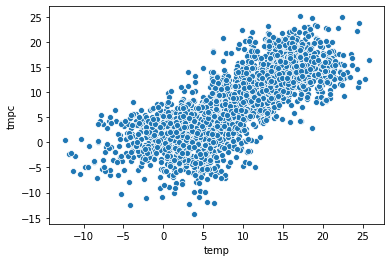

In [733]:
sns.scatterplot(x = 'temp', y = 'tmpc', data = df_merged_weather[df_merged_weather.ds <= '2019-12-31'])